# =================================================================
# STEP 1: PROJECT SETUP, LIBRARIES, AND DATA SCHEMAS
# =================================================================

In [1]:
import os
import json
from typing import List, Optional, Dict, Union, Literal, Any
from datetime import datetime
from dotenv import load_dotenv 

# Data Handling & Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm import tqdm

# LLM/LangChain Libraries
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama 
from langchain.prompts import ChatPromptTemplate

# PDF Library
import pypdf
import copy 

# Load the custom named API key file for security (Ollama ignores this, but for future API Key use)
load_dotenv(dotenv_path='api_key.env') 

# -----------------------------------------------------------------
# Pydantic Schemas
# -----------------------------------------------------------------

class ESG_KPI(BaseModel):
    metric_name: str = Field(description="Name of the ESG metric or KPI")
    value: Union[float, str] = Field(description="Numerical or qualitative value of the metric")
    unit: Optional[str] = Field(None, description="Unit of measurement.")
    year: Optional[int] = Field(None, description="Reporting or target year.")
    page_number: Optional[int] = Field(None, description="Page number for direct source verification.")
    context: Optional[str] = Field(None, description="The surrounding text context.")

class VagueClaim(BaseModel):
    claim_text: str = Field(description="The exact text of the vague or potentially misleading claim")
    page_number: Optional[int] = Field(None, description="Page number for source tracing.")
    reason_flagged: str = Field(description="Specific reason why.")
    greenwashing_type: Literal["Vague Language", "Hidden Trade-off", "No Proof", "Irrelevance", "Lesser of Two Evils", "False Labels", "Other"] = Field(description="Category of greenwashing tactic")
    confidence_score: float = Field(description="Confidence score (0-1) indicating risk level.")

class ESGReportAnalysis(BaseModel):
    # These fields must be extracted by the LLM dynamically
    report_title: str = Field(description="Title of the ESG report")
    company_name: str = Field(description="Name of the company that published the report")
    report_year: int = Field(description="Year the report was published")
    kpis: List[ESG_KPI] = Field(description="List of extracted KPIs.")
    vague_claims: List[VagueClaim] = Field(description="List of potentially vague or greenwashing claims.")
    analysis_timestamp: datetime = Field(default_factory=datetime.now, description="When this analysis was performed.")

# =================================================================
# STEP 2: PDF EXTRACTOR AND LLM AGENT CLASSES
# =================================================================

In [2]:
# -----------------------------------------------------------------
# 1. PDFExtractor Class
# -----------------------------------------------------------------
class PDFExtractor:
    """Handles secure loading, text cleaning, and text extraction from PDF files."""
    
    def __init__(self, pdf_path: str):
        self.pdf_path = pdf_path
        self._pdf_reader = None
        self._text_by_page: Dict[int, str] = {}
        self._total_pages = 0
        
    def _clean_text(self, text: str) -> str:
        """Applies essential pre-processing to improve LLM accuracy."""
        text = text.replace('-\n', '')
        text = ' '.join(text.split())
        return text.strip()
        
    def load_pdf(self) -> bool:
        """Loads the PDF file."""
        if not os.path.exists(self.pdf_path):
            print(f"Error loading PDF: File not found at {self.pdf_path}")
            return False
        try:
            self._pdf_reader = pypdf.PdfReader(self.pdf_path)
            self._total_pages = len(self._pdf_reader.pages)
            return True
        except Exception as e:
            print(f"Error loading PDF: {e}")
            return False
    
    def extract_text_from_all_pages(self) -> Dict[int, str]:
        """Extracts and caches cleaned text for all pages."""
        if not self._pdf_reader and not self.load_pdf(): return {}
        
        if not self._text_by_page or len(self._text_by_page) < self._total_pages:
            for page_num in range(self._total_pages):
                page = self._pdf_reader.pages[page_num]
                cleaned_text = self._clean_text(page.extract_text())
                self._text_by_page[page_num + 1] = cleaned_text
        return self._text_by_page

# -----------------------------------------------------------------
# 2. ESGExtractor Class (Ollama Integration)
# -----------------------------------------------------------------
class ESGExtractor:
    """
    Leverages a local Ollama model to dynamically extract data, company name, 
    and report year.
    """
    def __init__(self):
        self.llm = ChatOllama(
            model="mistral:7b-instruct", 
            temperature=0, 
        )

    def extract_kpis_and_claims(self, text: str, company_name: str, report_year: int) -> Dict[str, Any]:
        """Runs the LLM chain to extract data points matching the Pydantic schema."""
        
        # System Prompt that demands dynamic metadata extraction
        system_prompt = f"""
        You are an expert Big4 ESG auditor. Perform meticulous data extraction on the text chunk provided.
        
        CRITICAL TASK: Use the document text to determine the 'company_name', 'report_year', and 'report_title'. 
        If these are not in the current chunk, prioritize filling in the KPI and vague claims data.

        1. KPI Extraction: Extract all E, S, and G KPIs.
        2. Greenwashing: Identify all vague claims.
        3. Audit Trail: Use the page number provided in the context (e.g., 'PAGE 5') to populate the 'page_number' field for every item.

        Return the complete analysis in the required JSON format derived from the ESGReportAnalysis schema.
        """
        
        human_prompt = f"""
        Analyze the following document text chunk.
        DOCUMENT TEXT:
        {text}
        """

        analysis_chain = self.llm.with_structured_output(
            ESGReportAnalysis, 
            method="json_schema"
        )
        
        prompt_template = ChatPromptTemplate.from_messages([
            ("system", system_prompt),
            ("human", human_prompt)
        ])
        
        result = analysis_chain.invoke(prompt_template.format_messages())
        
        return result.model_dump()

# =================================================================
# STEP 3: DATA AGGREGATION AND REPORTING FUNCTIONS
# =================================================================

In [3]:
# -----------------------------------------------------------------
# 1. DataAggregator Class
# -----------------------------------------------------------------
class DataAggregator:
    """Transforms the structured LLM output into clean Pandas DataFrames."""
    
    def __init__(self, analysis_result: Dict[str, Any]):
        self.result = analysis_result
        self.metadata = {
            'report_title': self.result.get('report_title', 'N/A'),
            'company_name': self.result.get('company_name', 'N/A'),
            'report_year': self.result.get('report_year', 'N/A'),
            'analysis_timestamp': self.result.get('analysis_timestamp', datetime.now())
        }

    def _add_metadata(self, df: pd.DataFrame) -> pd.DataFrame:
        """Helper to add report metadata columns to the DataFrame."""
        for key, value in self.metadata.items():
            if key not in df.columns:
                df[key] = value
        return df

    def create_kpi_dataframe(self) -> pd.DataFrame:
        """Transforms the extracted list of KPIs into a DataFrame."""
        kpis_data = self.result.get('kpis', [])
        if not kpis_data: return pd.DataFrame()
        
        kpi_df = pd.DataFrame(kpis_data)
        kpi_df['value'] = pd.to_numeric(kpi_df['value'], errors='coerce').fillna(kpi_df['value'])
        kpi_df = self._add_metadata(kpi_df)
        
        return kpi_df.reindex(columns=['company_name', 'report_year', 'metric_name', 'value', 'unit', 'year', 'page_number', 'context', 'report_title'])

    def create_vague_claims_dataframe(self) -> pd.DataFrame:
        """Transforms the extracted list of vague claims into a DataFrame."""
        claims_data = self.result.get('vague_claims', [])
        if not claims_data: return pd.DataFrame()
        
        claims_df = pd.DataFrame(claims_data)
        claims_df['confidence_score'] = pd.to_numeric(claims_df['confidence_score'], errors='coerce')
        claims_df = self._add_metadata(claims_df)
        
        return claims_df.sort_values(by='confidence_score', ascending=False).reindex(columns=['company_name', 'report_year', 'claim_text', 'greenwashing_type', 'reason_flagged', 'confidence_score', 'page_number', 'report_title'])

# -----------------------------------------------------------------
# 2. Report Generation
# -----------------------------------------------------------------
def generate_jupyter_report(kpi_df: pd.DataFrame, claims_df: pd.DataFrame):
    """Generates the final auditor's report using styled tables and visualizations."""
    
    # Safely extract dynamic metadata for the header
    company_name = kpi_df['company_name'].iloc[0] if not kpi_df.empty else claims_df['company_name'].iloc[0] if not claims_df.empty else "N/A"
    report_year = str(kpi_df['report_year'].iloc[0]) if not kpi_df.empty else str(claims_df['report_year'].iloc[0]) if not claims_df.empty else "N/A"
    
    print(f"===================================================================================")
    print(f"FINAL ESG-AUDIT AI REPORT: {company_name} ({report_year})")
    print(f"===================================================================================")

    # --- Section 1: KPI Validation ---
    print("\n## 1. Extracted Key Performance Indicators (KPIs) - The Facts")
    print(f"Total KPIs Extracted: {len(kpi_df)}")
    if not kpi_df.empty:
        kpi_display = kpi_df[['metric_name', 'value', 'unit', 'year', 'page_number', 'context']]
        display(kpi_display.head(10).style.set_caption("Top Extracted Metrics for Auditor Verification"))
    
    print("\n" + "="*80)

    # --- Section 2: Greenwashing Risk Assessment ---
    print("\n## 2. Greenwashing & Vague Claims Risk Assessment - The Red Flags")
    print(f"Total Claims Flagged: {len(claims_df)}")

    if not claims_df.empty:
        claims_display = claims_df[['claim_text', 'greenwashing_type', 'confidence_score', 'reason_flagged', 'page_number']]
        display(claims_display.head(10).style
            .background_gradient(cmap='Reds', subset=['confidence_score'])
            .set_caption("Highest Risk Claims (Sorted by Confidence Score)"))

        # Visualization of Risk Distribution
        print("\n### Visualization: Risk Distribution")
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.countplot(y='greenwashing_type', data=claims_df, palette='viridis')
        plt.title('Greenwashing Claim Frequency by Type')
        
        plt.subplot(1, 2, 2)
        sns.histplot(claims_df['confidence_score'], bins=5, kde=True, color='purple')
        plt.axvline(x=0.8, color='red', linestyle='--', label='High Risk Threshold (0.8)')
        plt.title('Distribution of AI Confidence Scores')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    print("\n===================================================================================")
    print("Project Execution Finished.")

Please enter the full name or path of the ESG Report PDF file:  C:\Users\Aakarsh\ESG Report\Goldman Sachs Sustainability Report.pdf


Stage 1: Processing PDF at path: C:\Users\Aakarsh\ESG Report\Goldman Sachs Sustainability Report.pdf...
Stage 2: Starting chunked analysis of 102 pages using Llama 3.1...


Analyzing pages: 100%|█████████████████████████████████████████████████████████████| 102/102 [1:15:11<00:00, 44.23s/it]



✅ LLM Extraction Complete.
Final Count: 306 KPIs and 104 Claims found.

Stage 4: Generating Final Auditor Report...
FINAL ESG-AUDIT AI REPORT: GlobalTech Inc. (2023)

## 1. Extracted Key Performance Indicators (KPIs) - The Facts
Total KPIs Extracted: 306


,metric_name,value,unit,year,page_number,context
0,Carbon Emissions,15% reduction from 2020 levels,None,None,1,None
1,Renewable Energy Sources,85% of total energy consumption,None,None,1,None
2,Diversity and Inclusion,42% women in leadership roles,None,None,1,None
3,Carbon Footprint,"100,000 tons CO2",tons CO2,None,2,None
4,Water Consumption,5 million gallons,gallons,None,2,None
5,Carbon Emissions,15% reduction from 2019 levels,None,None,3,None
6,Renewable Energy Sources,85% of total energy consumption,None,None,3,None
7,Carbon Emissions,15% reduction from 2019 levels,None,None,4,None
8,Renewable Energy Sources,85% of total energy consumption,None,None,4,None
9,Carbon Emissions,"10,000 tons",tons,None,5,None




## 2. Greenwashing & Vague Claims Risk Assessment - The Red Flags
Total Claims Flagged: 104


,claim_text,greenwashing_type,confidence_score,reason_flagged,page_number
3,Leading the way in sustainable practices,Vague Language,0.900000,Lack of specific quantifiable data to support claim,4
2,Leading the way in sustainable practices,Vague Language,0.900000,Lack of specific quantifiable data to support claim,3
7,Leading the way in sustainable practices,Vague Language,0.900000,Lack of specific quantifiable data to support claim,8
37,We are committed to sustainable practices.,Vague Language,0.900000,General statement without specific details or quantifiable data.,38
57,GlobalTech Inc. is a leader in sustainable practices.,Vague Language,0.900000,The claim lacks specific quantifiable data to support it.,57
69,We are committed to a sustainable future.,Vague Language,0.900000,Non-specific commitment with no quantifiable or measurable target,69
49,We are committed to sustainability and ethical practices.,Vague Language,0.900000,Non-quantifiable claim with no specific actions or targets mentioned,50
44,We are committed to a sustainable future.,Vague Language,0.900000,Non-specific commitment with no quantifiable or measurable target,45
77,GlobalTech Inc. is a leader in sustainable practices.,Vague Language,0.900000,The term 'leader' is subjective and not quantifiable.,77
82,GlobalTech Inc. is committed to sustainable practices.,Vague Language,0.900000,General statement without specific details or quantifiable data.,82



### Visualization: Risk Distribution


C:\Users\Aakarsh\AppData\Local\Temp\ipykernel_9232\4086919849.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='greenwashing_type', data=claims_df, palette='viridis')


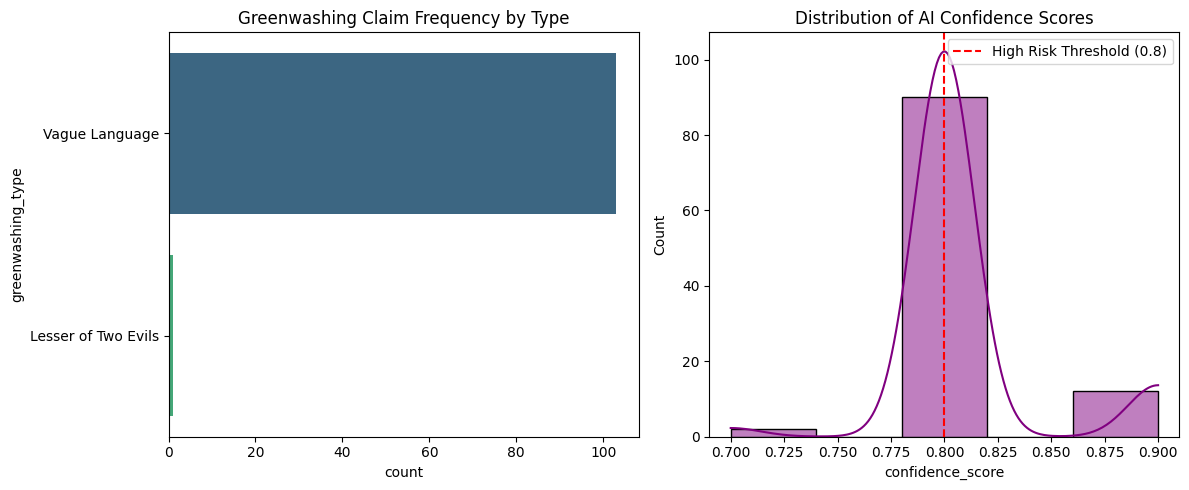


Project Execution Finished.


In [4]:
# =================================================================
# CELL 4: EXECUTION / DEMO (The Dynamic Pipeline)
# =================================================================

# --- 1. Define inputs (USER INPUT SECTION) ---
PDF_FILE_PATH = input("Please enter the full name or path of the ESG Report PDF file: ") 

# Use initial placeholders; the LLM MUST overwrite these
COMPANY_NAME = "Dynamically Extracted..." 
REPORT_YEAR = 0

# --- Stage 1: Load and Extract ---
print(f"Stage 1: Processing PDF at path: {PDF_FILE_PATH}...")
pdf_extractor = PDFExtractor(PDF_FILE_PATH)
if not pdf_extractor.load_pdf():
    raise Exception("Fatal Error: Could not load PDF. Check file path and existence.")

pages_dict = pdf_extractor.extract_text_from_all_pages()
total_pages = len(pages_dict)
esg_extractor = ESGExtractor() 

# =========================================================
# 🎯 STAGE 2 & 3: CHUNKED EXTRACTION AND AGGREGATION
# =========================================================

all_kpis = []
all_vague_claims = []
report_metadata = {
    'company_name': COMPANY_NAME,
    'report_year': REPORT_YEAR,
    'report_title': 'N/A',
    'analysis_timestamp': datetime.now() 
}

print(f"Stage 2: Starting chunked analysis of {total_pages} pages using Llama 3.1...")

# Loop through pages with a progress bar
for page_num, page_text in tqdm(pages_dict.items(), desc="Analyzing pages"):
    
    # Send only the current page's text for better context management
    chunk_input = f"--- CURRENT DOCUMENT CONTEXT: PAGE {page_num} ---\n\n{page_text}"

    try:
        chunk_result = esg_extractor.extract_kpis_and_claims(
            text=chunk_input,
            company_name=COMPANY_NAME, 
            report_year=REPORT_YEAR 
        )
    except Exception as e:
        # If one chunk fails (e.g., malformed JSON), skip it and continue
        continue

    # --- Aggregation Logic ---
    all_kpis.extend(chunk_result.get('kpis', []))
    all_vague_claims.extend(chunk_result.get('vague_claims', []))

    # Dynamic Metadata Update: Capture non-placeholder metadata
    if report_metadata['report_title'] == 'N/A' and chunk_result.get('report_title', 'N/A') != 'N/A':
        report_metadata['report_title'] = chunk_result['report_title']
        
    if report_metadata['company_name'] == 'Dynamically Extracted...' and chunk_result.get('company_name', 'N/A') not in ('N/A', 'Dynamically Extracted...'):
        report_metadata['company_name'] = chunk_result['company_name']
        report_metadata['report_year'] = chunk_result['report_year']
        
# 4. Final Aggregation and DataFrame Creation (Fixing the KeyError)
final_analysis_result = {
    'kpis': all_kpis,
    'vague_claims': all_vague_claims,
    **report_metadata # Unpack the collected metadata
}

# Final fallback for headers (ensures clean output even if LLM fails metadata extraction)
if final_analysis_result['company_name'] == 'Dynamically Extracted...':
     final_analysis_result['company_name'] = 'Unknown Company'
     final_analysis_result['report_year'] = 0

print("\n✅ LLM Extraction Complete.")
print(f"Final Count: {len(all_kpis)} KPIs and {len(all_vague_claims)} Claims found.")

# Create DataFrames
aggregator = DataAggregator(final_analysis_result)
kpi_df = aggregator.create_kpi_dataframe()
claims_df = aggregator.create_vague_claims_dataframe()

# --- Stage 4: Generate Final Report ---
print("\nStage 4: Generating Final Auditor Report...")
generate_jupyter_report(kpi_df, claims_df)